# Paso 1: Configuración inicial y librerías

In [19]:
# Paso 1: Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
from datetime import datetime

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# Configurar semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Verificar versión de TensorFlow
print(f"Versión de TensorFlow: {tf.__version__}")

# Verificar si hay GPU disponible
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


Versión de TensorFlow: 2.18.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Paso 2: Cargar y explorar el dataset CIFAR-10

In [20]:
# Paso 2: Cargar el dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Nombres de las clases
class_names = ['avión', 'automóvil', 'pájaro', 'gato', 'ciervo',
               'perro', 'rana', 'caballo', 'barco', 'camión']

# Verificar las dimensiones
print("Tamaño de x_train:", x_train.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de x_test:", x_test.shape)
print("Tamaño de y_test:", y_test.shape)
print("Valores de píxeles: min =", x_train.min(), ", max =", x_train.max())


Tamaño de x_train: (50000, 32, 32, 3)
Tamaño de y_train: (50000, 1)
Tamaño de x_test: (10000, 32, 32, 3)
Tamaño de y_test: (10000, 1)
Valores de píxeles: min = 0 , max = 255


# Paso 3: Visualización de ejemplos e inspección de clases

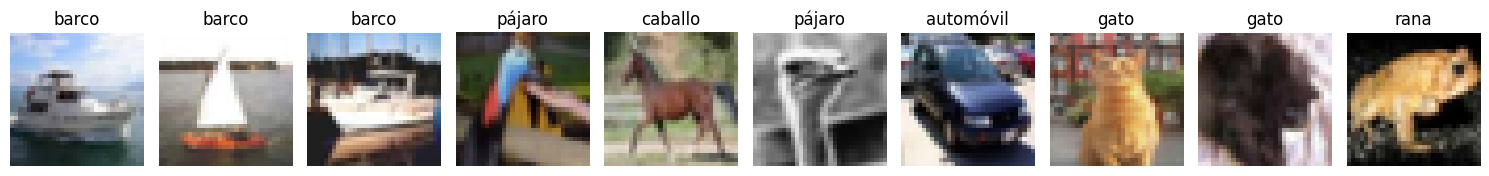

In [21]:
# Función para visualizar imágenes del dataset
def plot_sample_images(X, y, class_names, n_samples=10):
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        idx = np.random.randint(0, X.shape[0])
        plt.subplot(1, n_samples, i+1)
        plt.imshow(X[idx])
        plt.title(class_names[y[idx][0]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar imágenes de entrenamiento
plot_sample_images(x_train, y_train, class_names)


# Paso 4: Preprocesamiento de datos (normalización y codificación)

In [22]:
# Normalizar valores de píxeles a rango [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convertir etiquetas a one-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Confirmar formas
print("x_train:", x_train.shape)
print("y_train_cat:", y_train_cat.shape)


x_train: (50000, 32, 32, 3)
y_train_cat: (50000, 10)


# Paso 5: Data Augmentation con ImageDataGenerator

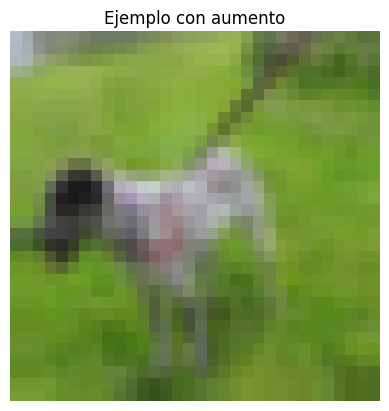

In [23]:
# Crear generador de datos con aumentos
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(x_train)

# Verificar una muestra aumentada
it = datagen.flow(x_train, y_train_cat, batch_size=1)
x_batch, y_batch = next(it)

plt.imshow(x_batch[0])
plt.title("Ejemplo con aumento")
plt.axis("off")
plt.show()


# Paso 6: Crear el modelo denso (MLP) con regularización y activaciones modernas

In [24]:
from tensorflow.keras import regularizers

# Aplanar las imágenes (32x32x3 = 3072)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Regularización L1 + L2
regularizador = regularizers.L1L2(l1=1e-5, l2=1e-4)

# Definir el modelo secuencial
modelo = Sequential([
    Input(shape=(3072,)),

    Dense(2048, kernel_regularizer=regularizador),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),

    Dense(1024, kernel_regularizer=regularizador),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),

    Dense(512, kernel_regularizer=regularizador),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),

    Dense(256, kernel_regularizer=regularizador),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),

    Dense(10, activation='softmax')  # CIFAR-10 tiene 10 clases
])

# Resumen del modelo
modelo.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,065,738 (34.58 MB)

 Trainable params: 9,058,058 (34.55 MB)

 Non-trainable params: 7,680 (30.00 KB)

# Paso 7: Compilar el modelo (SGD con momentum + Nesterov)

In [25]:
# Definir el optimizador SGD
optimizador = SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

# Compilar el modelo
modelo.compile(
    optimizer=optimizador,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Paso 8: Entrenamiento del modelo con callbacks

In [30]:
# Directorio para logs y checkpoints
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "mejor_modelo.keras"

# Callbacks
callbacks = [
    TensorBoard(log_dir=log_dir),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Entrenamiento
historial = modelo.fit(
    x_train_flat, y_train_cat,
    validation_data=(x_test_flat, y_test_cat),
    epochs=100,
    batch_size=128,
    callbacks=callbacks
)


Epoch 1/100
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7062 - loss: 1.5353
Epoch 1: val_loss improved from inf to 2.00539, saving model to mejor_modelo.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7063 - loss: 1.5351 - val_accuracy: 0.5741 - val_loss: 2.0054 - learning_rate: 6.2500e-04
Epoch 2/100
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7224 - loss: 1.5031
Epoch 2: val_loss did not improve from 2.00539
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7224 - loss: 1.5030 - val_accuracy: 0.5708 - val_loss: 2.0268 - learning_rate: 6.2500e-04
Epoch 3/100
383/391 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7210 - loss: 1.4911
Epoch 3: val_loss did not improve from 2.00539
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7211 - loss: 1.4908 - val_accuracy: 0.5710 - val_loss: 2.0323 - learning_rate: 6.2500e-04
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7258 - loss: 1.4794
Epoch 4: val_loss did not improve from 

# Paso 9: Visualizar el accuracy y loss

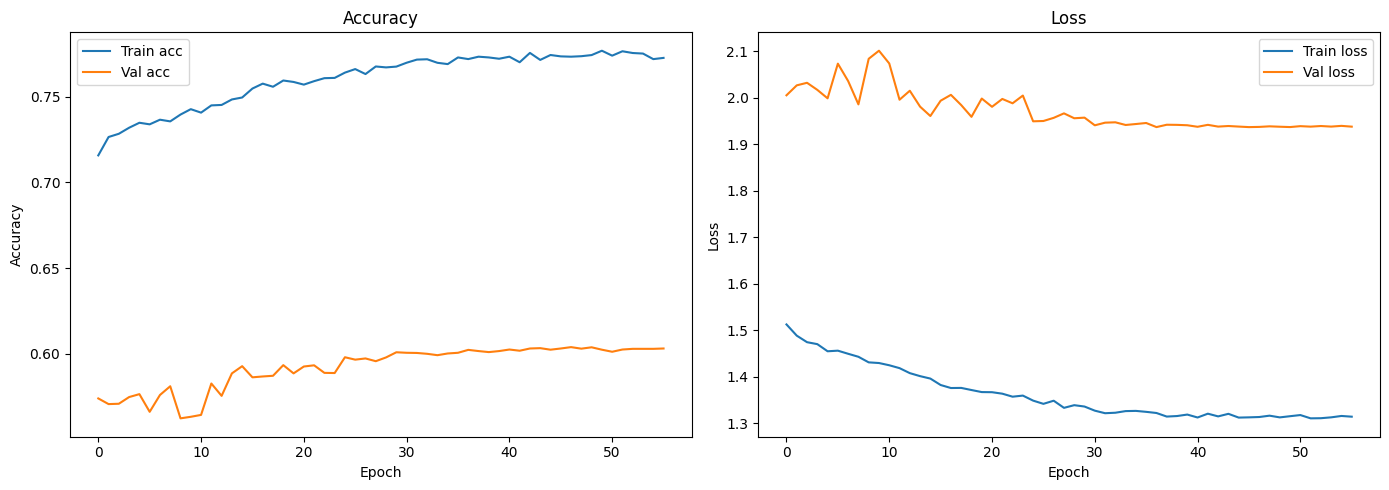

In [33]:
# Graficar precisión y pérdida
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(historial.history['accuracy'], label='Train acc')
plt.plot(historial.history['val_accuracy'], label='Val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(historial.history['loss'], label='Train loss')
plt.plot(historial.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Paso 10: Evaluación del modelo y reporte por clase

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

       avión       0.68      0.67      0.67      1000
   automóvil       0.72      0.68      0.70      1000
      pájaro       0.53      0.45      0.49      1000
        gato       0.41      0.45      0.43      1000
      ciervo       0.51      0.57      0.54      1000
       perro       0.52      0.47      0.49      1000
        rana       0.65      0.69      0.67      1000
     caballo       0.67      0.66      0.67      1000
       barco       0.71      0.74      0.73      1000
      camión       0.64      0.65      0.65      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



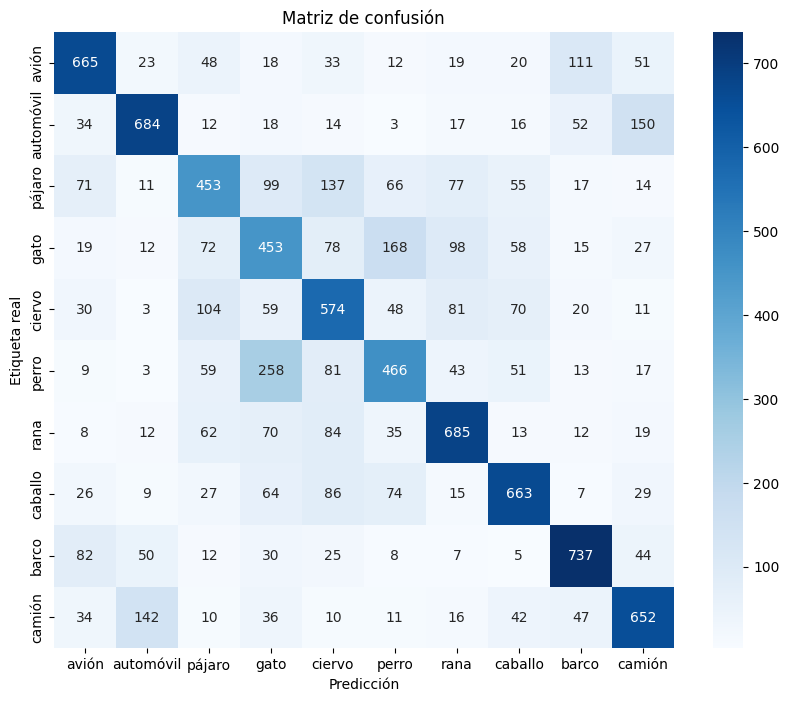

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predecir en el set de test
y_pred_probs = modelo.predict(x_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Mostrar clasificación por clase
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión')
plt.show()


# Paso 11: Probar el modelo con imágenes individuales

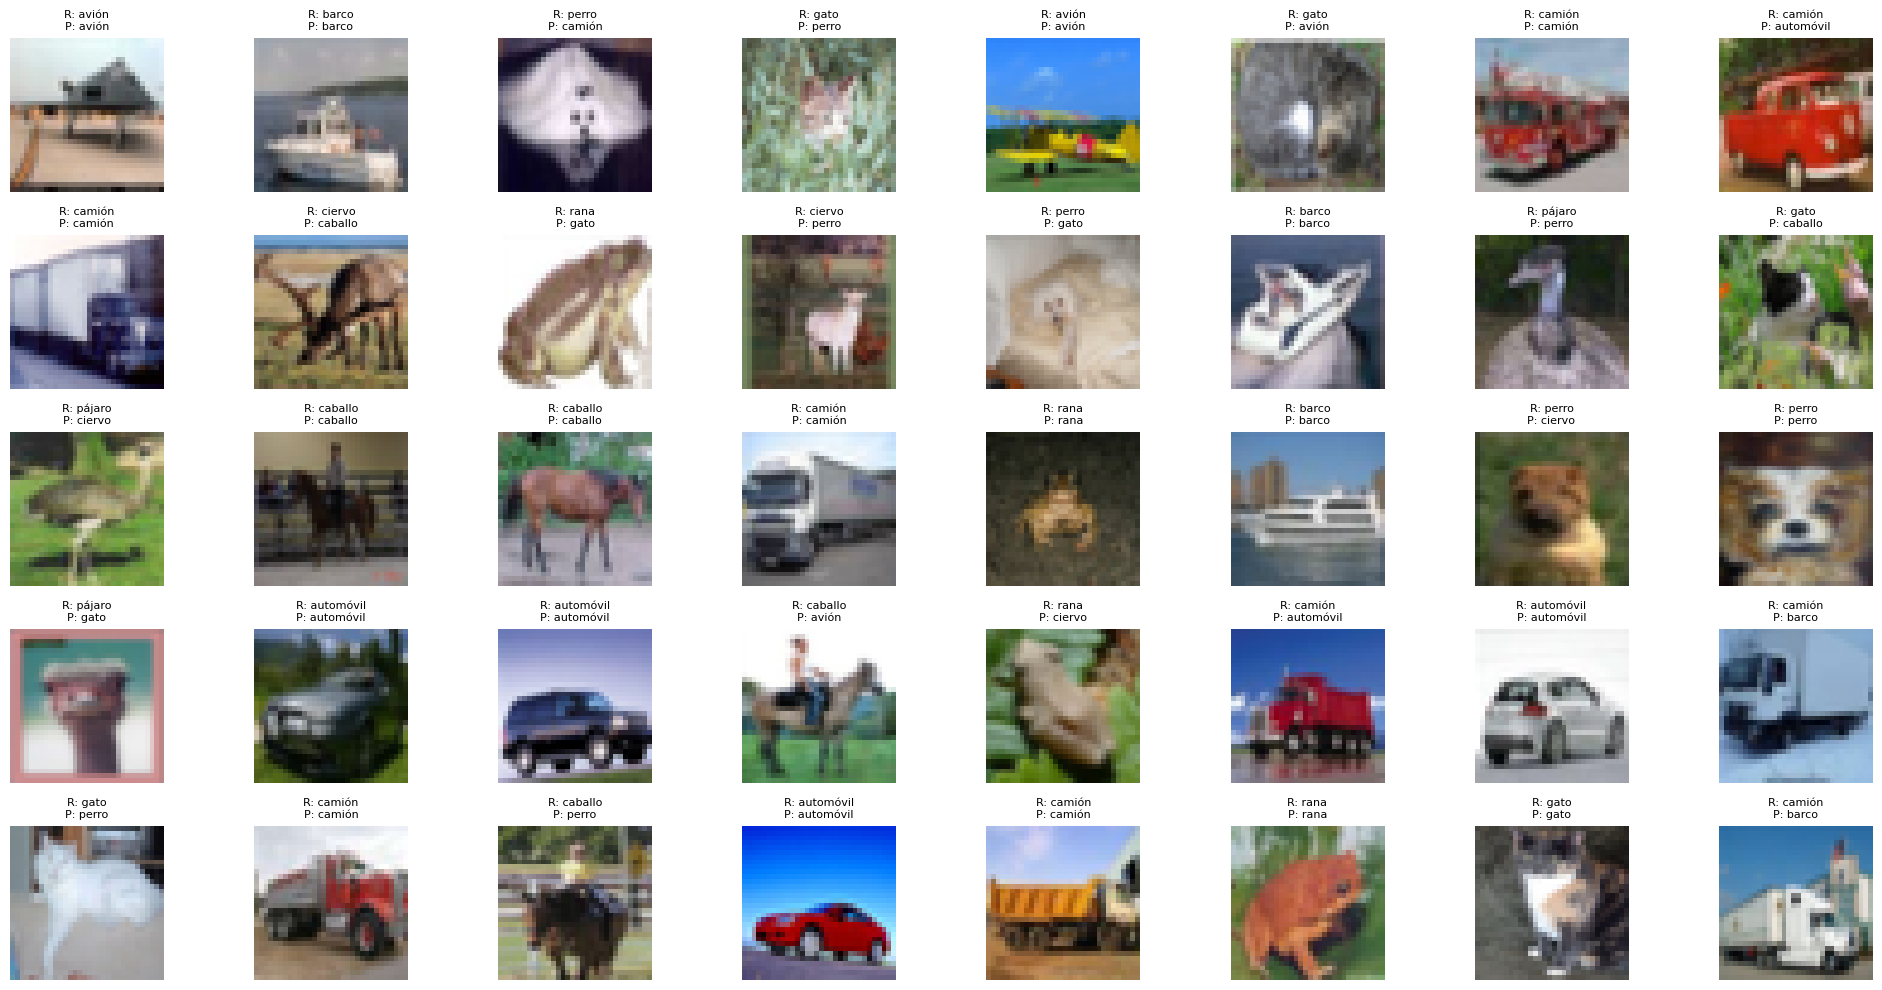

In [35]:
# Mostrar 40 imágenes aleatorias con predicciones
num_images = 40
indices = np.random.choice(len(x_test_flat), num_images, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    img = x_test[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]

    plt.subplot(5, 8, i + 1)
    plt.imshow(img)
    plt.title(f"R: {true_label}\nP: {pred_label}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()